In [1]:
import torch
import torchvision
import datetime
import os
import matplotlib.pyplot as plt

C:\Users\mvanderloo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This notebook uses a pretrained GAN from the repo below, as well as the Generator and Discriminator definiton 
# https://github.com/csinva/gan-vae-pretrained-pytorch/tree/master/cifar10_dcgan

In [3]:
latent_dims = 100 # size of generator input
image_size = 32 # one dimension of image size (will be square)
device = torch.device('cuda:0') # needs CUDA enabled GPU 

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# put the location of the training set here
training_set_path = "X:\lafayette_dataset\dataset"

# transform the training set to the right size and pixel values between -1 and 1
dataset = datasets.ImageFolder(root=training_set_path,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

# should be 3x32x32
print(dataset[0][0].shape)

torch.Size([3, 32, 32])


In [5]:
# this is a function to put a tensor's values from [-1, 1] to [0, 255] to allow a normalized image to be printed
def denormalize_image_tensor(tensor, min=-1, max=1):
    tensor = ((tensor - min) / (max - min))
    return tensor

# prints a tensor
def print_tensor(image):
    plt.axis(False)
    plt.imshow(transforms.ToPILImage()(denormalize_image_tensor(image)), interpolation="bicubic")
    

In [6]:
import torch.nn as nn
import torch.optim as optim

# definition of Generator
class Generator(nn.Module):
    def __init__(self, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        # 4 convolutional stage DCGAN Generator
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        # needs CUDA enabled device
        return nn.parallel.data_parallel(self.main, input, [device])

# create generator and load onto CUDA device
netG = Generator().to(device)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.002, betas=(0.5, 0.999))

# load pretrained weights
g_weights = torch.load("weights/netG_pretrained.pth")

# randomly initialize trainable layers for transfer learning
g_weights['main.10.weight'] = torch.rand(64)
g_weights['main.10.bias'] = torch.rand(64)
g_weights['main.12.weight'] = torch.rand(64, 3, 1, 1)

# init model with the weights
netG.load_state_dict(g_weights)

# freeze all up to second to last convolution
for i, param in enumerate(netG.parameters()):
    if i < 10:
        param.requires_grad = False


In [7]:
import torch.nn as nn
import torch.optim as optim

# definition of Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        # 4 convolutional stage DCGAN Discriminator
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        # needs CUDA enabled device
        output = nn.parallel.data_parallel(self.main, input, range(1))
        return output.view(-1, 1).squeeze(1)

# create generator and load onto CUDA device
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.002, betas=(0.5, 0.999))

# load pretrained weights
d_weights = torch.load("weights/netD_pretrained.pth")

# randomly initialize trainable layers for transfer learning
d_weights['main.9.weight'] = torch.rand(512)
d_weights['main.9.bias'] = torch.rand(512)
d_weights['main.11.weight'] = torch.rand(1, 512, 2, 2)

# init model with the weights
netD.load_state_dict(d_weights)

# freeze layers we don't want to train
for i, param in enumerate(netD.parameters()):
    if i < 8:
        param.requires_grad = False

In [10]:
batch_size = 4096
numEpochs = 5

# initialize data loader on dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=int(1))
criterion = nn.BCELoss()

# make output directories
dir_id = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
outfile = "output/" + dir_id
weightfile = "weights/" + dir_id
os.mkdir(outfile)
os.mkdir(weightfile)
print(f"outputing to {dir_id}")

# use same tensor for outputing images over time to compare
fixed_noise = torch.randn(batch_size, latent_dims, 1, 1, device=device)

for epoch in range(numEpochs):
        for i, data in enumerate(dataloader, 0):
            ## Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), 1.0, device=device) # real label
            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, latent_dims, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.0) # fake label
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ## Update Generator: maximize log(D(G(z)))
            netG.zero_grad()
            label.fill_(1.0)  # use real label generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Output to console
            print('Epoch: %d/%d Batch: %d/%d Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, numEpochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            if i % 100 == 0:
                torchvision.utils.save_image(real_cpu, '%s/real_samples.png' % outfile, normalize=True)
                generated = netG(fixed_noise)
                torchvision.utils.save_image(generated.detach(), '%s/fake_samples_epoch_%03d.png' % (outfile, epoch), normalize=True)

        # do checkpointing
        torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (weightfile, epoch))
        torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (weightfile, epoch))

outputing to 20221216215712
Epoch: 0/5 Batch: 0/1 Loss_D: 3.0962 Loss_G: 7.4593 D(x): 0.9989 D(G(z)): 0.0996 / 0.0598
Epoch: 1/5 Batch: 0/1 Loss_D: 5.9683 Loss_G: 7.1658 D(x): 0.9939 D(G(z)): 0.2445 / 0.0891


RuntimeError: CUDA out of memory. Tried to allocate 954.00 MiB (GPU 0; 8.00 GiB total capacity; 4.98 GiB already allocated; 0 bytes free; 6.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

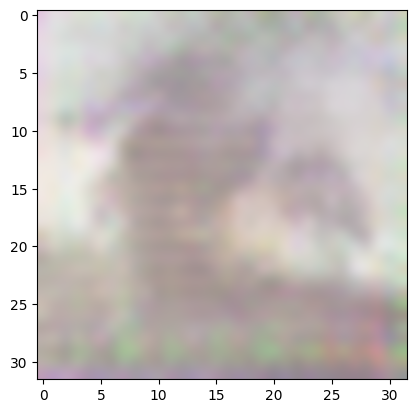

In [ ]:
# can use after training to see an example output in Jupyter
print_tensor(netG(torch.randn(1, 100, 1, 1, device=0))[0])